In [1]:
import numpy as np
import matplotlib.pyplot as plt
import math

In [344]:
class Performative_Regression:

    def __init__(self, k, n , T, sigma=1, M=1):
        """
        Parameters:
        - k (int): Polynomial degree.
        - n (int): Number of samples for each theta_i.
        - T (float): Total number of rounds, should be > kn.
        - sigma (float, optional): Standard deviation of the noise. Default is 1.
        - M (float, optional): Bound of the derivatives of f. Default is 1.
        """
        self.k = k
        self.n = n
        self.T = T
        self.sigma = sigma
        self.M = M

        # Produce k+1 Chebyshev nodes
        self.thetas = np.cos(np.pi * (2*np.arange(1, self.k+2) - 1 ) / (2*(self.k + 1)))

        self.f_hat_values = self.f_hat()
        
        
    def f(self, theta):
        """
        Computes the true function value at a given Chebyshev node.

        Parameters:
        - theta (float): A number between -1 and 1.

        Returns:
        - float: The function value at the specified theta.
        """

        fun = np.cos(theta) - np.sin(theta)
        #fun = np.e**theta / (theta**2 + 0.5)
        
        return fun
    
    def f_hat(self):
        """
        Generates the array of noisy function values at the Chebyshev nodes.

        Returns:
        - numpy.ndarray: Array with element i equal to f_hat(theta_i) where theta_i is the ith Chebyshev node.
        """
        
        Y = (
            np.repeat(self.f(self.thetas)[:, np.newaxis], self.n, axis=1) +
            np.random.normal(0, self.sigma, (self.k+1, self.n))
        )

        f_hat = np.mean(Y, axis=1)

        return f_hat

    def vandermonde_matrix(self):
        """
        Computes the Vandermonde matrix with Chebyshev nodes.

        Returns:
        - numpy.ndarray: The Vandermonde matrix.
        """

        return np.vander(self.thetas, increasing=True)

    def vandermonde_determinant(self):
        """
        Computes the determinant of the Vandermonde matrix.

        Returns:
        - float: The determinant of the Vandermonde matrix.
        """

        det = (-1)**((self.k+1) * self.k / 2 ) * ((self.k+1)**(self.k+1) / 2**(self.k*self.k))**(1/2)
        
        return det   
    
    def true_objective_function(self, theta):
        """
        Computes the true objective function at a given Chebyshev node.

        Parameters:
        - theta (float): A number between -1 and 1.

        Returns:
        - float: The true objective function evaluated at theta.
        """

        return self.f(theta)**2 - 2 * theta * self.f(theta) + theta**2
    
    def g_hat(self, theta):
        """
        Computes the estimated g_hat at a given theta.

        Parameters:
        - theta (float): A number between -1 and 1.

        Returns:
        - float: The estimated function value at the specified theta.
        """
        p_theta = 0
        for i in range(self.k+1):
            prod = 1
            for j in range(self.k+1):
                if j != i:
                    prod = prod * (theta - self.thetas[j]) / (self.thetas[i] - self.thetas[j])

            p_theta = p_theta + prod * self.f_hat_values[i]
        
        return p_theta

    def estimated_objective_function(self, theta):
        """
        Computes the estimated objective function value at a given theta.

        Parameters:
        - theta (float): A number between -1 and 1.

        Returns:
        - float: The estimated objective function value at the specified theta.
        """

        g_estimate = self.g_hat(theta)

        return g_estimate**2 - 2 * theta * g_estimate + theta**2

    def remainder(self, theta):
        """
        Computes the upper bound of the absolute value of the remainder term for a given theta.

        Parameters:
        - theta (float): A number between -1 and 1.

        Returns:
        - float: The upper bound of the absolute value of the remainder term at the specified theta.
        """

        cheb_polynomial = np.cos((self.k+1)*np.arccos(theta))/(2**(self.k))

        return self.M * np.abs(cheb_polynomial) / math.factorial(self.k + 1)

    def lagrange_bound(self, theta):
        """
        Computes the sum of the absolute value of the Lagrange polynomials.

        Parameters:
        - theta (float): A number between -1 and 1.

        Returns:
        - float: The sum of the absolute value of the Lagrange polynomials.
        """

        sum_new = 0
        for i in range(self.k+1):
            sum_new += np.abs(
                (-1)**i * np.sin(np.pi * (2*i + 1) / (2*self.k + 2)) * np.cos((self.k+1)*np.arccos(theta)) / (self.k+1) / (theta - self.thetas[i])
            )

        return sum_new
    
    def conf_interval_at_theta(self, theta):

        """
        Computes the confidence interval at a theta.

        Parameters:
        - theta (float): A number between -1 and 1.

        Returns:
        - float: The confidence interval at the specified theta.
        """
        B_1 = self.remainder(theta)
        B_2 = self.lagrange_bound(theta) * 1.96 * self.sigma / np.sqrt(self.n)
        
        return B_1 + B_2

    def minimum(self):

        t = np.linspace(-1, 1, 10000)
        gs = self.estimated_objective_function(t)
        fs = self.true_objective_function(t)
        estimated_min = t[np.argmin(gs)]
        true_min = t[np.argmin(fs)]
        return estimated_min, true_min

    def plot_f_vs_g(self):
        
        t = np.linspace(-1, 1, 1000)
        
        plt.plot(t, self.f(t), 'C0', label=r'$f(\theta)$')
        plt.plot(t, self.g_hat(t), 'C0--', label=r"$\hat{g}(\theta)$")
        plt.fill_between(t,
                         self.g_hat(t) - self.conf_interval_at_theta(t),
                         self.g_hat(t) + self.conf_interval_at_theta(t),
                         alpha=0.3,
                         color="C0")
        

    def plot_objectives(self):
        
        t = np.linspace(-1, 1, 1000)
        ci = self.conf_interval_at_theta(t)
        ci_2 = ci**2 + 2 * ci * (self.g_hat(t) - t)
        ci_3 = ci**2 - 2 * ci * (self.g_hat(t) - t)
        plt.plot(t, self.true_objective_function(t), 'C1', label='true objective')
        plt.plot(t, self.estimated_objective_function(t), 'C1--', label=f'estimated objective for k={self.k}')
        #plt.fill_between(t,
        #                 self.estimated_objective_function(t) + ci_3,
        #                 self.estimated_objective_function(t) + ci_2,
        #                 alpha=0.3,
        #                 color='C1')

        estimated_min = self.minimum()[0]
        true_min = self.minimum()[1]
        plt.scatter(estimated_min, self.true_objective_function(estimated_min), label=r'$\theta_{PO}$', color='k')
        plt.scatter(true_min, self.true_objective_function(true_min), label=r'$\hat{\theta}_{PO}$', marker='x', color='r')
        plt.xlabel(r"$\theta$")



        


In [345]:
pr.conf_interval_at_theta(1)

2.4176194541776956

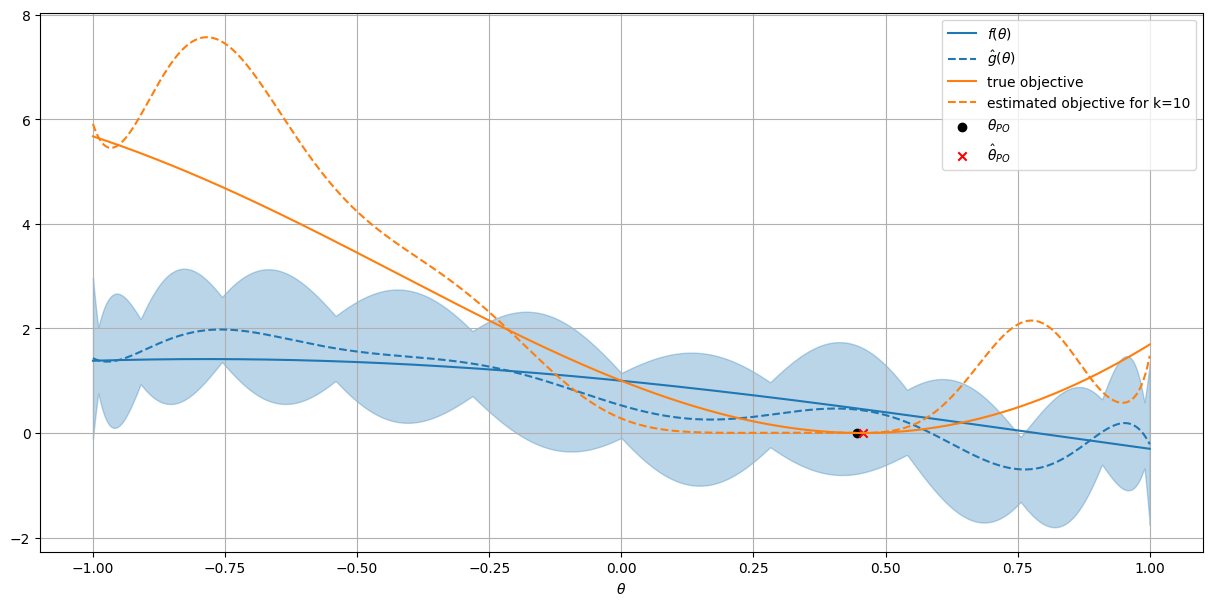

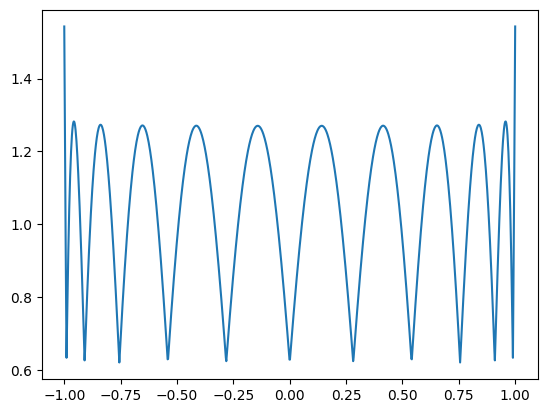

In [356]:
k=10
pr = Performative_Regression(k=k, n=10, T=1, sigma=1, M=4)
plt.figure(figsize=(15, 7))
pr.plot_f_vs_g()
pr.plot_objectives()

plt.grid()
plt.legend()
plt.show()
plt.plot(t, pr.conf_interval_at_theta(t))